# Linear Bivariate BMM with JETSCAPE models : step mixing

<!-- The best way to learn Taweret is to use it. You can run, modify and experiment with this notebook [here.](https://mybinder.org/v2/gh/danOSU/Taweret/c2d8fd3ce3d74a5891d51adb5afc0afa0b503127?urlpath=lab%2Ftree%2Fdocs%2Fsource%2Fnotebooks%2FLinear_BMM_with_step_function_for_SAMBA_models.ipynb) -->



This notebook shows how to use the Bayesian model mixing package **Taweret** for a toy problem. 

Author : Dan Liyanage 

Date : 01/03/2023



In [1]:
import sys
import os
os.environ["WORKDIR"] = "/Users/dananjayaliyanage/git/Taweret/subpackages/js-sims-bayes"
# You will have to change the following imports depending on where you have 
# the packages installed
# If using binder please uncomment the followings.
#sys.path.append("/home/jovyan/")
sys.path.append("/Users/dananjayaliyanage/git/Taweret/subpackages/js-sims-bayes/src")
sys.path.append("/Users/dananjayaliyanage/git/Taweret/")

from configurations import *
from emulator import *
#sys.path.append("/Users/dananjayaliyanage/git/Taweret")
#sys.path.append("/Users/dananjayaliyanage/git/Taweret/subpackages/SAMBA")

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
# To define priors. (uncoment if not using default priors)
#import bilby

# For other operations
import numpy as np
import bilby

Using idf = 3 : Pratt-Torrieri-Bernhard
SystemsInfo = 
{'Pb-Pb-2760': {'proj': 'Pb', 'targ': 'Pb', 'sqrts': 2760, 'main_design_file': '/Users/dananjayaliyanage/git/Taweret/subpackages/js-sims-bayes/production_designs/design_pts_Pb_Pb_2760_production/design_points_main_PbPb-2760.dat', 'main_range_file': '/Users/dananjayaliyanage/git/Taweret/subpackages/js-sims-bayes/production_designs/design_pts_Pb_Pb_2760_production/design_ranges_main_PbPb-2760.dat', 'validation_design_file': '/Users/dananjayaliyanage/git/Taweret/subpackages/js-sims-bayes/production_designs/design_pts_Pb_Pb_2760_production/design_points_validation_PbPb-2760.dat', 'validation_range_file': '/Users/dananjayaliyanage/git/Taweret/subpackages/js-sims-bayes/production_designs/design_pts_Pb_Pb_2760_production//design_ranges_validation_PbPb-2760.dat', 'labels': ['$N$[$2.76$TeV]', '$p$', '$\\sigma_k$', '$w$ [fm]', '$d_{\\mathrm{min}}$ [fm]', '$\\tau_R$ [fm/$c$]', '$\\alpha$', '$T_{\\eta,\\mathrm{kink}}$ [GeV]', '$a_{\\eta,\\math

In [2]:
!echo ${WORKDIR}

/Users/dananjayaliyanage/git/Taweret/subpackages/js-sims-bayes


## 1. Get toy models and the experimental data

In [3]:
obs_to_remove = ['dN_dy_Lambda', 'dN_dy_Omega', 'dN_dy_Xi']

In [4]:
# Toy models from SAMBA
from Taweret.models import jetscape_sims_models as sims

m1 = sims.jetscape_models_pb_pb_2760(fix_MAP=True,model_num=0, obs_to_remove=obs_to_remove)
m2 = sims.jetscape_models_pb_pb_2760(fix_MAP=True,model_num=3, obs_to_remove=obs_to_remove)
exp = sims.exp_data()

Loading experimental data from /Users/dananjayaliyanage/git/Taweret/subpackages/js-sims-bayes/HIC_experimental_data


g

In [5]:
g = np.linspace(0, 60, 20)
plot_g = np.linspace(0.0,60,100)
m1_prediction = m1.evaluate(g)
m2_prediction = m2.evaluate(g)
#true_output = truth.evaluate(plot_g)
exp_data= exp.evaluate(g,obs_to_remove=obs_to_remove)

['dNch_deta', 'dET_deta', 'dN_dy_pion', 'dN_dy_kaon', 'dN_dy_proton', 'mean_pT_pion', 'mean_pT_kaon', 'mean_pT_proton', 'pT_fluct', 'v22', 'v32', 'v42']


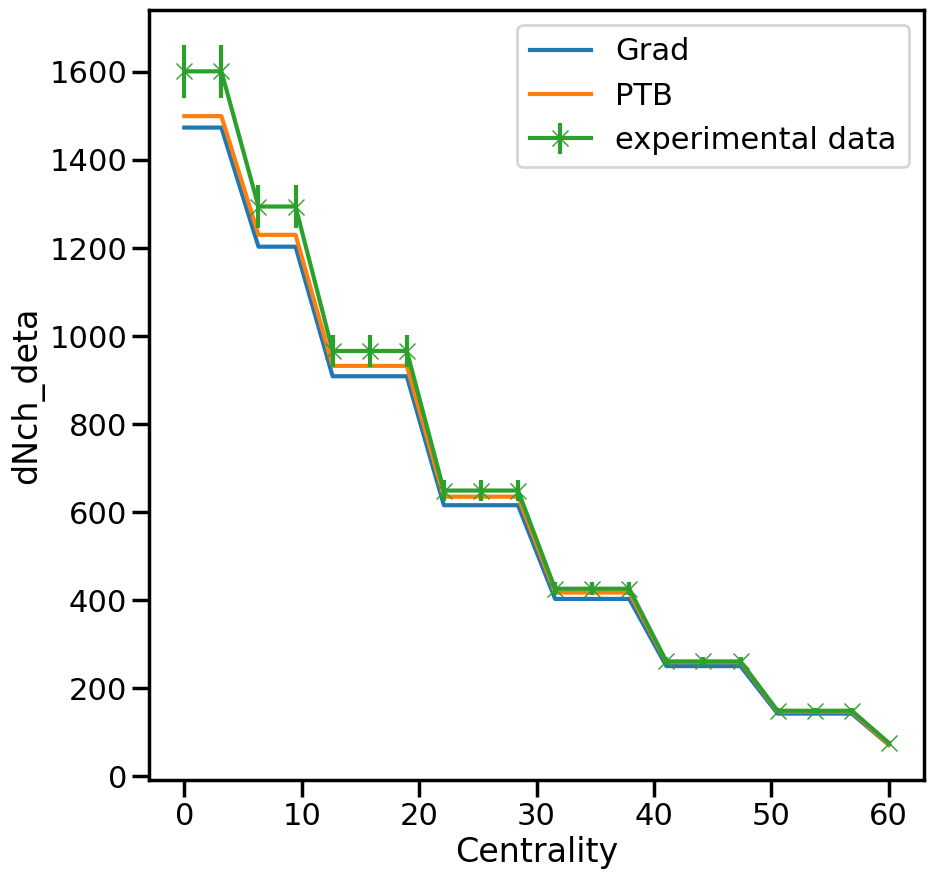

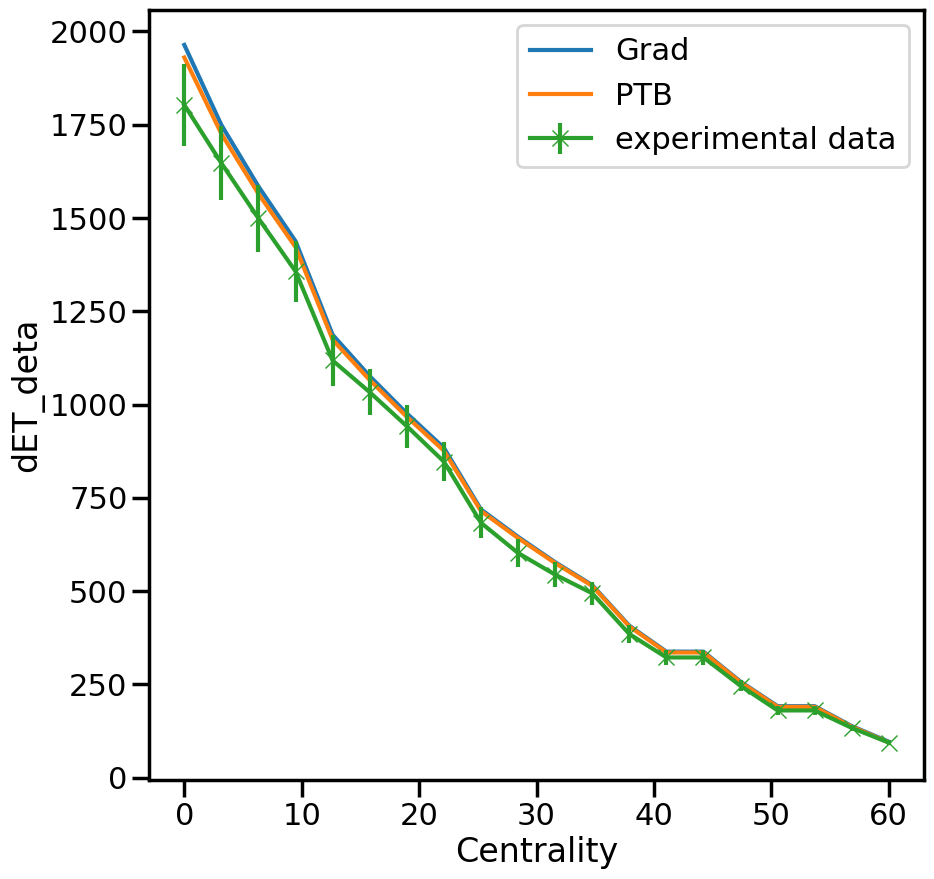

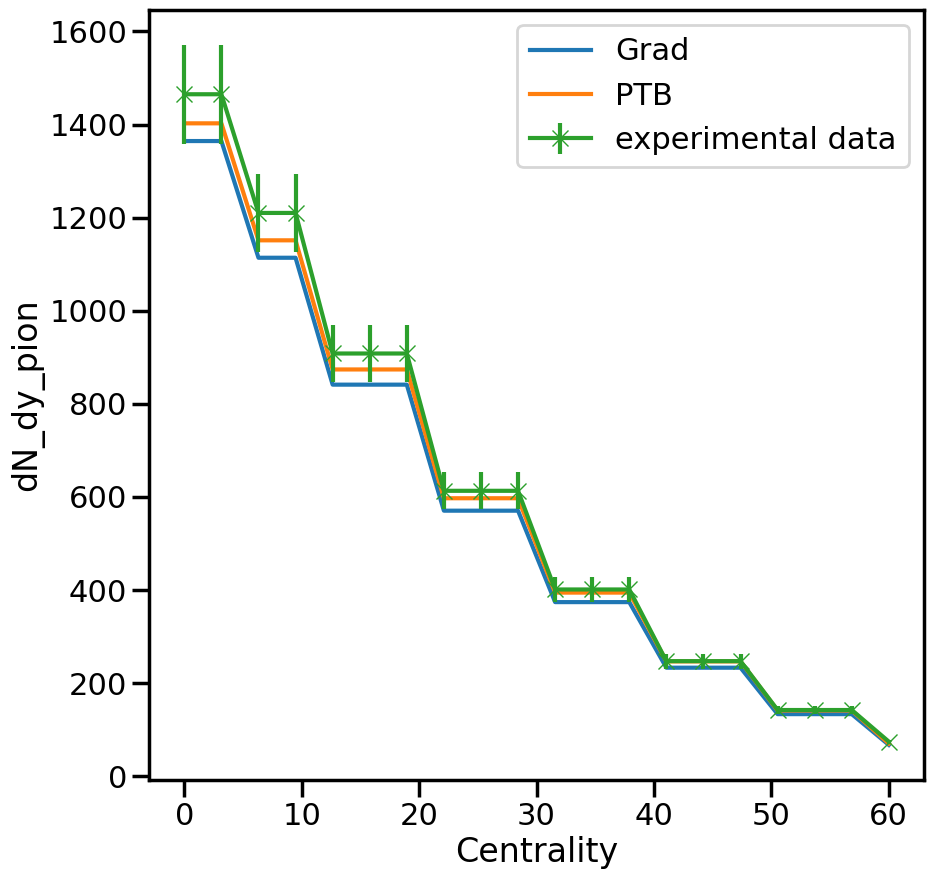

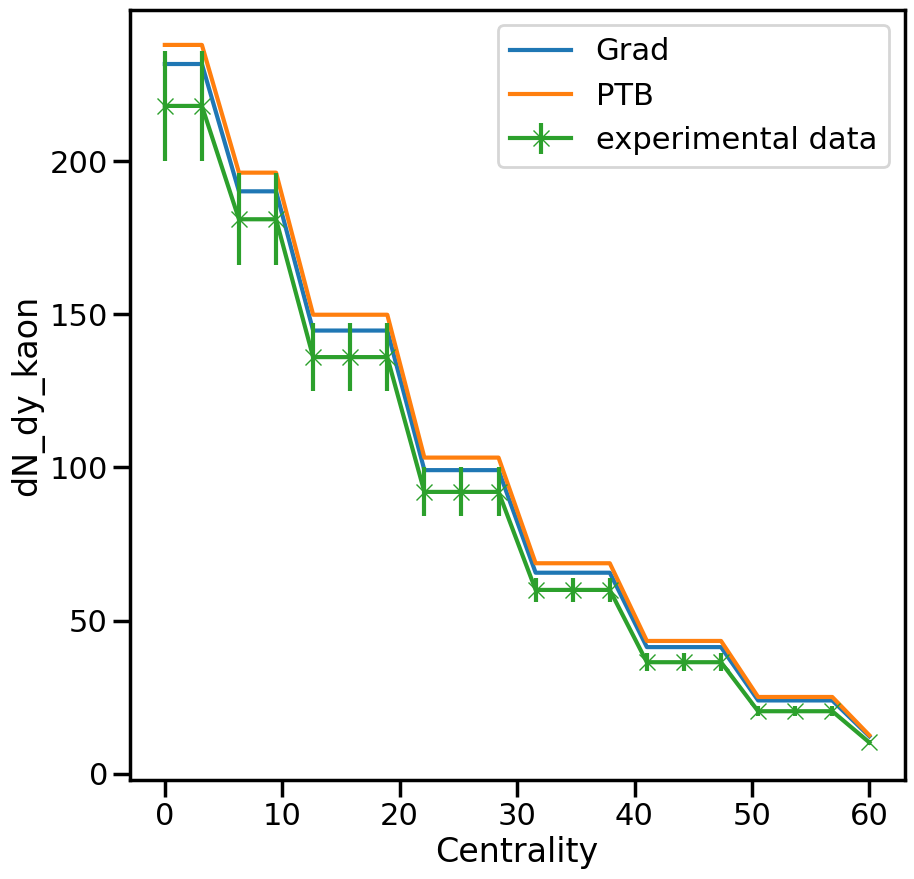

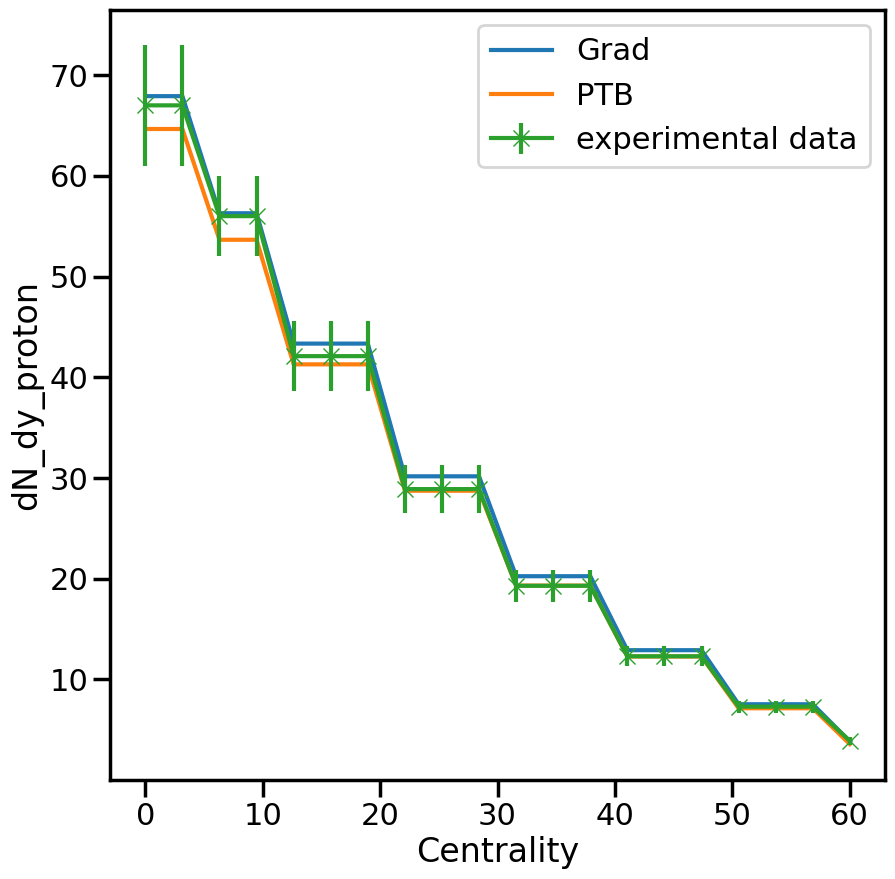

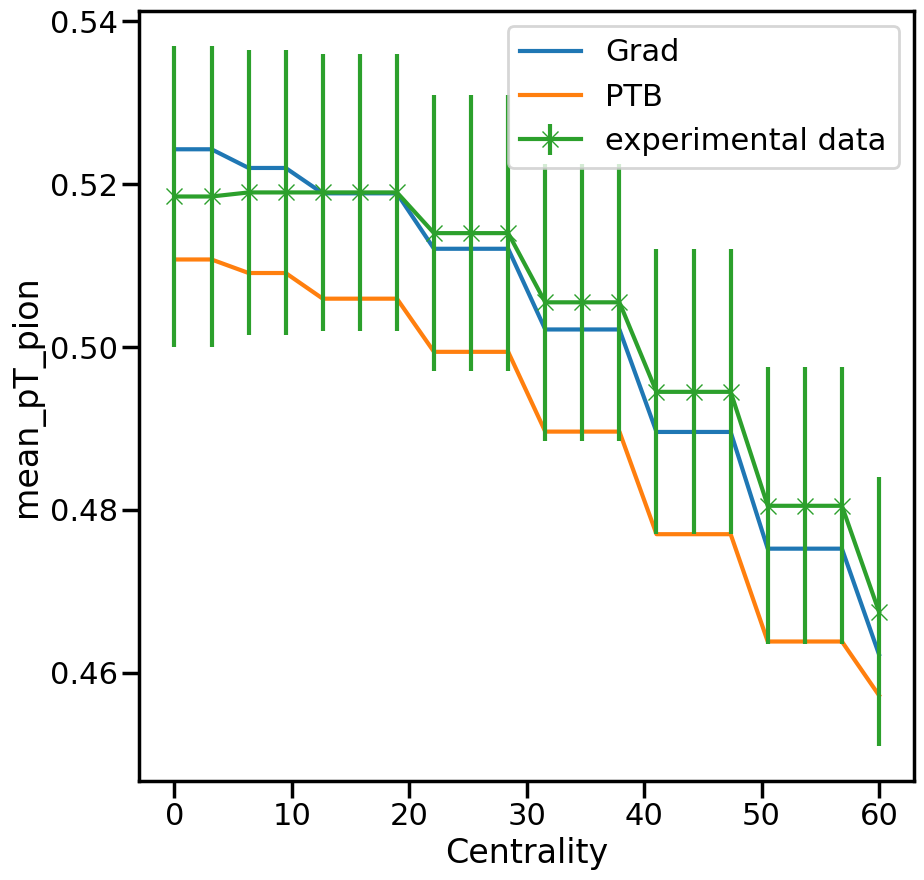

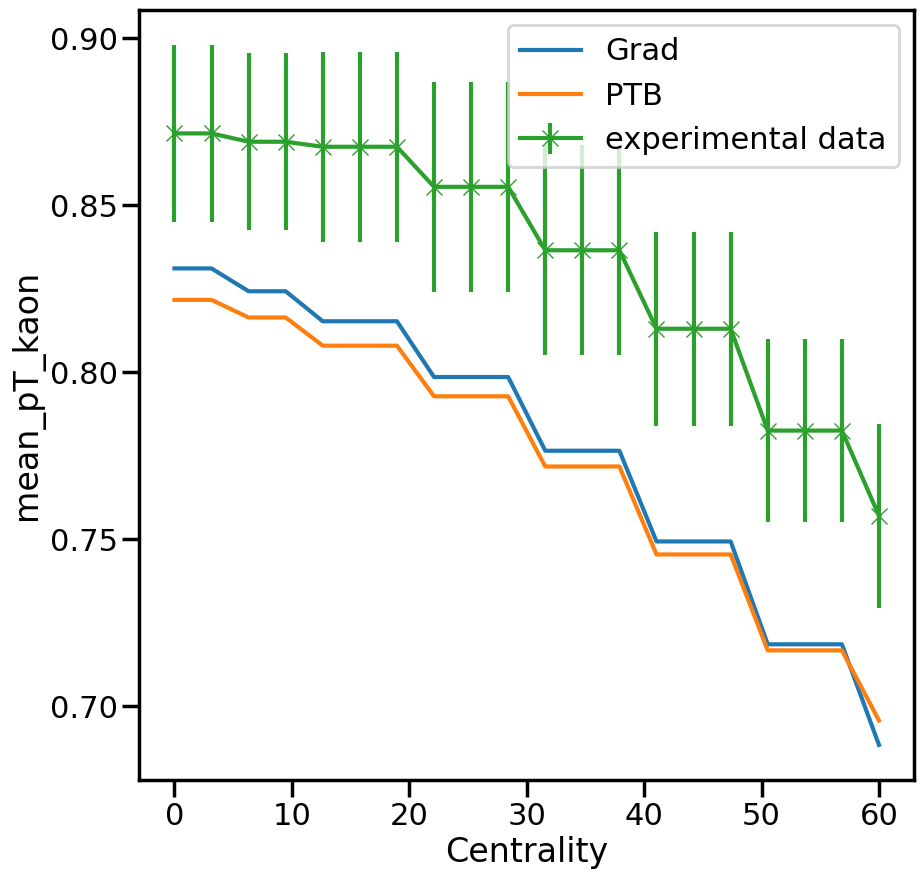

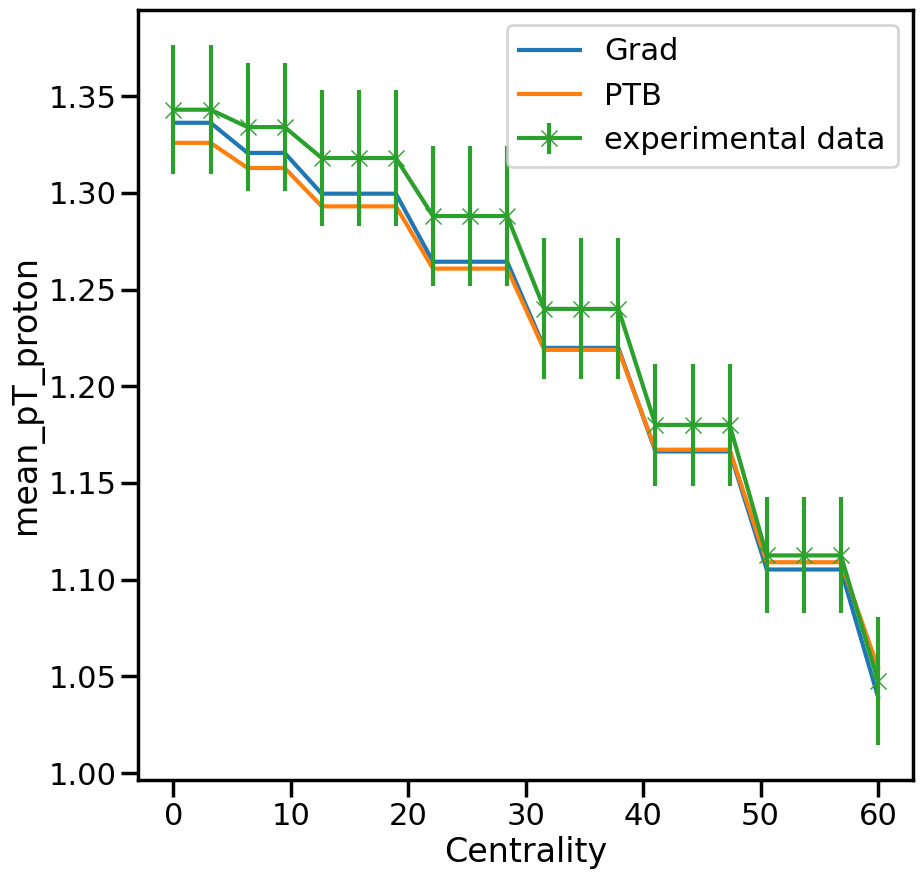

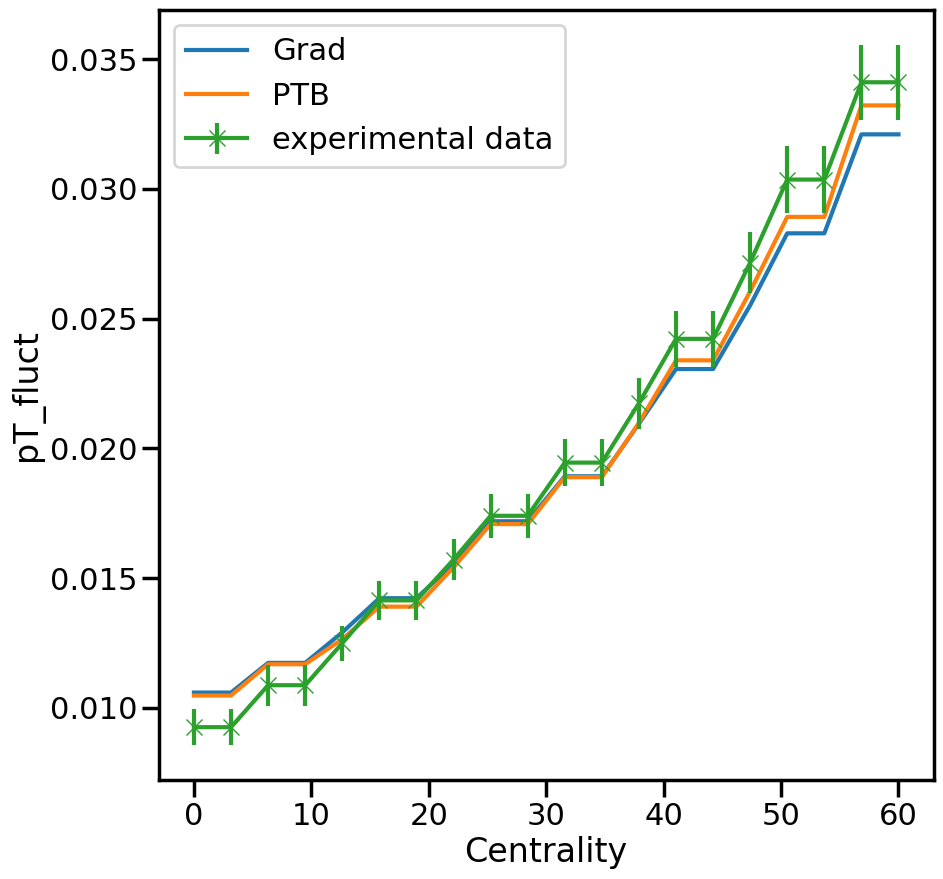

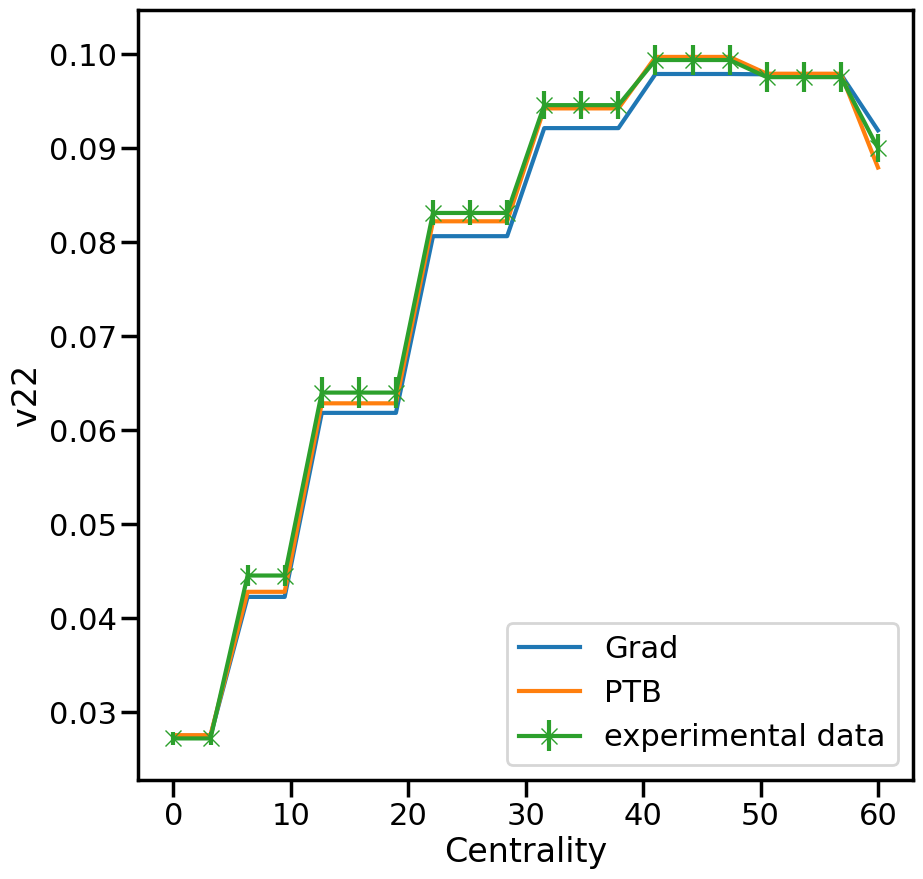

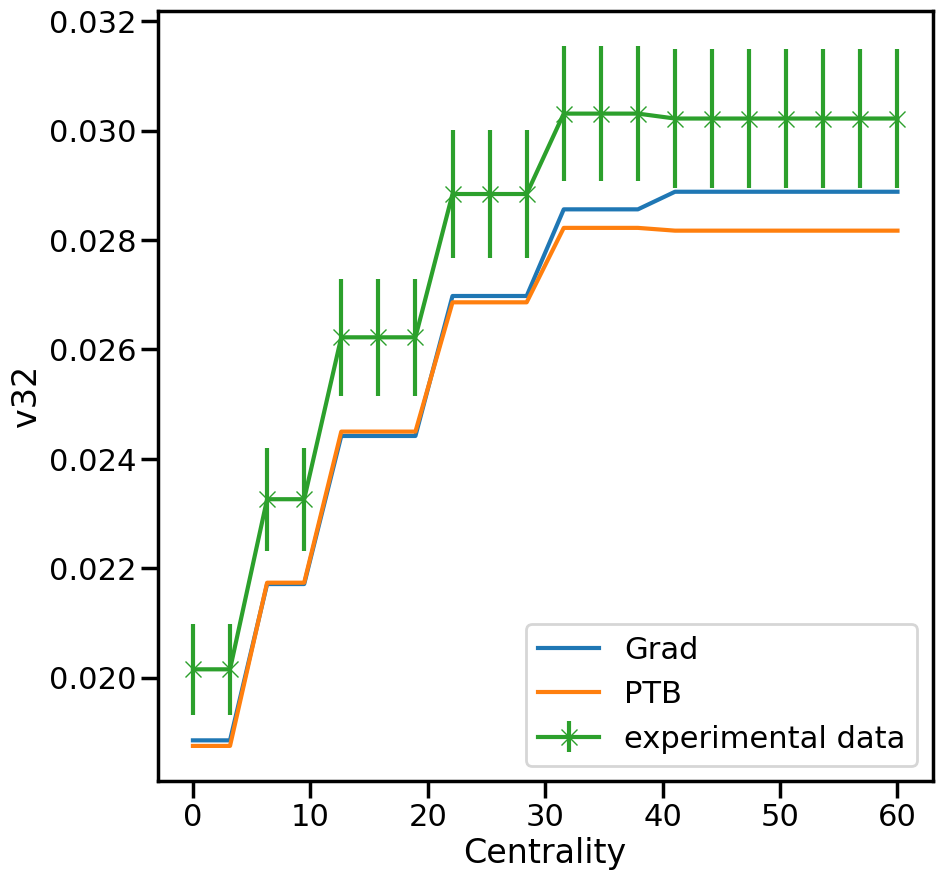

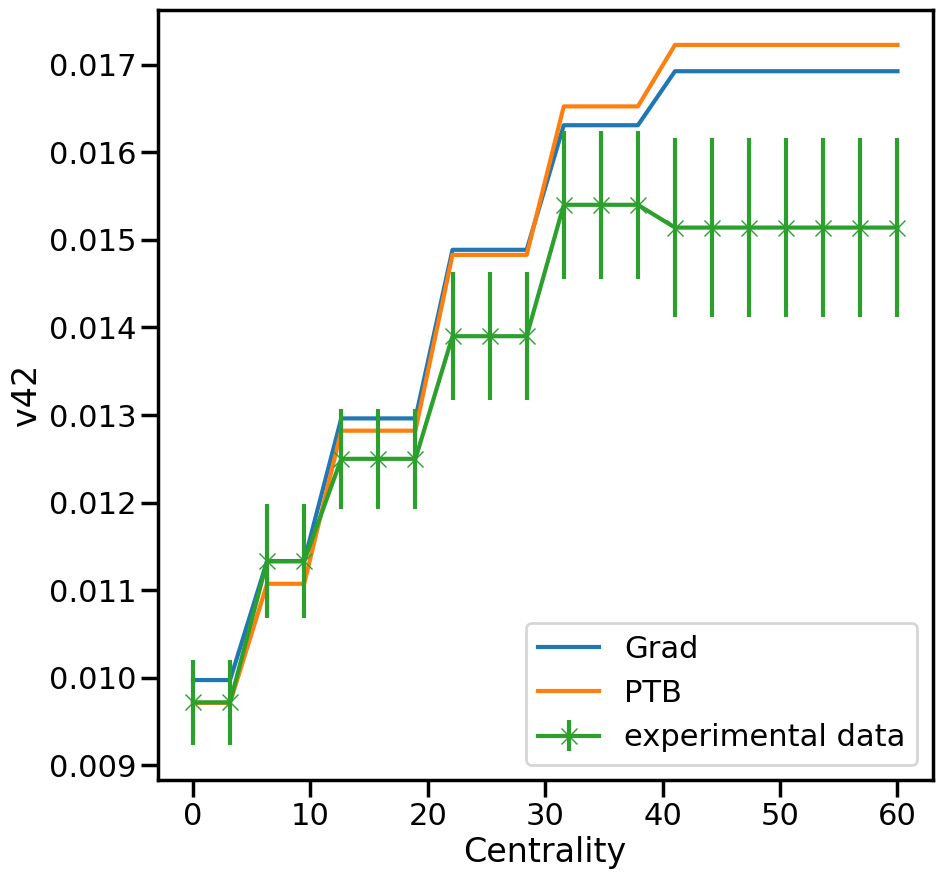

In [6]:
obs_names = list(obs_cent_list['Pb-Pb-2760'].keys())
for i in obs_to_remove:
    obs_names.remove(i)
print(obs_names)
for i in range(0,12):
    fig, ax_f = plt.subplots(figsize=(10,10))
    ax_f.plot(g, m1_prediction[0][:,i].flatten(), label='Grad')
    ax_f.plot(g, m2_prediction[0][:,i].flatten(), label='PTB')
    #ax_f.plot(plot_g, true_output[0], label='truth')
    #ax_f.scatter(g,exp_data[0][:,i].flatten(), marker='x', label='experimental data')
    ax_f.set_xlabel('Centrality')
    ax_f.errorbar(g,exp_data[0][:,i].flatten(), 
                yerr=exp_data[1][:,i].flatten(),
                marker='x', label='experimental data')
    #ax_f.set_ylim(1.2,3.2)
    ax_f.set_ylabel(obs_names[i])
    ax_f.legend()

##  2. Choose a Mixing method

In [7]:
from Taweret.core.base_model import BaseModel
isinstance(m1, BaseModel)

True

In [8]:
# Mixing method
from Taweret.mix.bivariate_linear import BivariateLinear as BL

models= {'Grad':m1,'PTB':m2}
mix_model = BL(models_dic=models, method='addstep')

addstep mixing function has 2 free parameter(s)
To change the prior use `set_prior` method


In [9]:
#uncoment to change the prior from the default
priors = bilby.core.prior.PriorDict()
priors['addstep_0'] = bilby.core.prior.Uniform(0, 60, name="addstep_0")
priors['addstep_1'] = bilby.core.prior.Uniform(0, 1, name="addstep_1")
mix_model.set_prior(priors)

{'addstep_0': Uniform(minimum=0, maximum=60, name='addstep_0', latex_label='addstep_0', unit=None, boundary=None),
 'addstep_1': Uniform(minimum=0, maximum=1, name='addstep_1', latex_label='addstep_1', unit=None, boundary=None)}

## 3. Train to find posterior

In [11]:
#sampler_args = {'sampler': 'ptemcee', 'ntemps': 5, 'nwalkers': 20, 'Tmax': 100, 'burn_in_fixed_discard': 200, 'nsamples': 2000, 'printdt': 60}

In [10]:
#result = mix_model.train(x_exp=g, y_exp=exp_data[0], y_err=exp_data[1], outdir = 'outdir/samba_bivaraite', label='step_mix')
outdir = 'outdir/samba_bivaraite_grad_ptb_total_addstep'
result = mix_model.train(x_exp=g, y_exp=exp_data[0], y_err=exp_data[1], outdir = outdir, label='addstep_mix', 
                        load_previous=True,)
                        #kwargs_for_sampler=sampler_args)

23:33 bilby INFO    : Running for label 'addstep_mix', output will be saved to 'outdir/samba_bivaraite_grad_ptb_total_addstep'
23:33 bilby INFO    : Search parameters:
23:33 bilby INFO    :   addstep_0 = Uniform(minimum=0, maximum=60, name='addstep_0', latex_label='addstep_0', unit=None, boundary=None)
23:33 bilby INFO    :   addstep_1 = Uniform(minimum=0, maximum=1, name='addstep_1', latex_label='addstep_1', unit=None, boundary=None)


Saved results do not exist in : outdir/samba_bivaraite_grad_ptb_total_addstep/addstep_mix
The following Default settings for sampler will be used. You can change    these arguments by providing kwargs_for_sampler argement in `train`.    Check Bilby documentation for other sampling options.
{'sampler': 'ptemcee', 'ntemps': 10, 'nwalkers': 200, 'Tmax': 100, 'burn_in_fixed_discard': 500, 'nsamples': 8000, 'threads': 7, 'printdt': 60}


23:33 bilby INFO    : Single likelihood evaluation took 1.611e-02 s
23:33 bilby WARNING : Supplied argument 'printdt' not an argument of 'Ptemcee', removing.
23:33 bilby INFO    : Using sampler Ptemcee with kwargs {'ntemps': 10, 'nwalkers': 200, 'Tmax': 100, 'betas': None, 'a': 2.0, 'adaptation_lag': 10000, 'adaptation_time': 100, 'random': None, 'adapt': False, 'swap_ratios': False}
23:33 bilby INFO    : Using convergence inputs: ConvergenceInputs(autocorr_c=5, autocorr_tol=50, autocorr_tau=1, gradient_tau=0.1, gradient_mean_log_posterior=0.1, Q_tol=1.02, safety=1, burn_in_nact=50, burn_in_fixed_discard=500, mean_logl_frac=0.01, thin_by_nact=0.5, nsamples=8000, ignore_keys_for_tau=None, min_tau=1, niterations_per_check=5)
23:33 bilby INFO    : Generating pos0 samples
23:34 bilby INFO    : Starting to sample


1|0:00:39|nc:1.0e+04|a0:0.00-1.00|swp:0.73-0.99|n:nan<8000|t!nan(+nan,+nan)|q:inf|3.91ms/ev
2|0:01:17|nc:2.0e+04|a0:0.20-1.00|swp:0.71-0.99|n:nan<8000|t!nan(+nan,+nan)|q:inf|3.85ms/ev
3|0:01:56|nc:3.0e+04|a0:0.20-0.87|swp:0.71-0.99|n:nan<8000|t!nan(+nan,+nan)|q:inf|3.89ms/ev
4|0:02:34|nc:4.0e+04|a0:0.30-0.85|swp:0.70-0.99|n:nan<8000|t!nan(+nan,+nan)|q:inf|3.86ms/ev
5|0:03:12|nc:5.0e+04|a0:0.24-0.80|swp:0.70-0.99|n:nan<8000|t!nan(+nan,+nan)|q:inf|3.85ms/ev


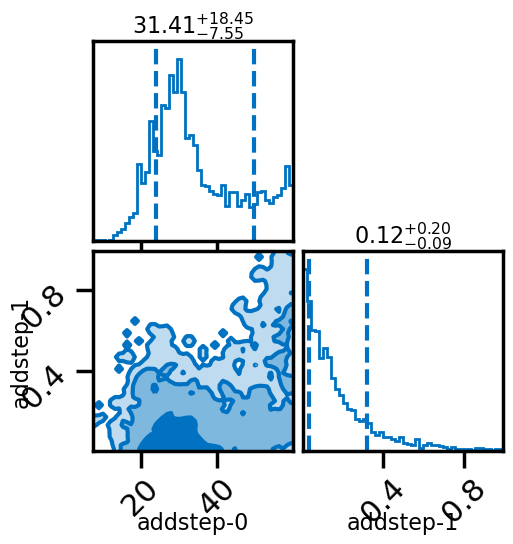

In [ ]:
# Posterior of the mixing parameters. 
result.plot_corner()

In [ ]:
result.posterior

,addstep_0,addstep_1,log_likelihood,log_prior
0,50.530710,0.149935,139.090559,-4.094345
1,59.133650,0.116559,139.129409,-4.094345
2,44.910978,0.014663,139.883345,-4.094345
3,26.331019,0.055731,141.267712,-4.094345
4,29.503473,0.014315,141.838627,-4.094345
...,...,...,...,...
2015,29.891310,0.049421,141.562380,-4.094345
2016,50.819786,0.126212,139.140641,-4.094345
2017,21.913704,0.187289,139.958240,-4.094345
2018,27.429628,0.256792,139.705841,-4.094345


## 4. Predictions

In [ ]:
_,mean_prior,CI_prior, _ = mix_model.prior_predict(g, CI=[5,20,80,95])
_,mean,CI, _ = mix_model.predict(g, CI=[5,20,80,95])

(10000, 1)
using provided samples instead of posterior


In [ ]:
per5, per20, per80, per95 = CI
prior5, prior20, prior80, prior95 = CI_prior

In [ ]:
per5.shape

(1, 12, 20)

In [ ]:
mix_model.map

array([-20.24412154])

In [ ]:
# Map value prediction for the step mixing function parameter
map_prediction = mix_model.evaluate(mix_model.map, g)

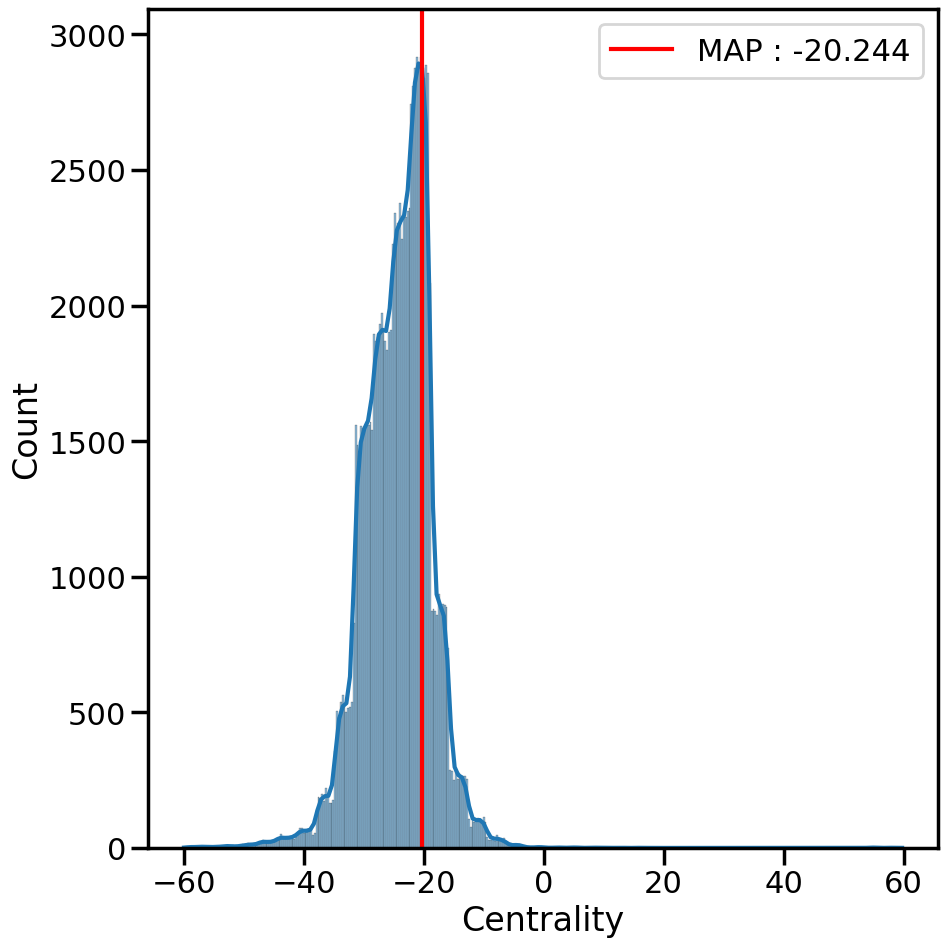

In [ ]:
import os
fig, ax_hist = plt.subplots(figsize=(10,10))
sns.histplot(data=result.posterior, x='step_0', kde=True, ax=ax_hist)
ax_hist.axvline(x = mix_model.map, color = 'r', label = f'MAP : {mix_model.map[0]:.3f}') 
ax_hist.set_xlabel('Centrality')
ax_hist.legend()
os.makedirs(outdir+'/figures/', exist_ok = True)
plt.tight_layout()
fig.savefig(outdir+'/figures/'+'MAP_', dpi=100)

In [ ]:
obs_tex_labels = {
                    'dNch_deta' : r'$dN_{ch}/d\eta$',
                    'dN_dy_pion' : r'$dN_{\pi}/dy$',
                    'dN_dy_kaon' : r'$dN_{k}/dy$',
                    'dN_dy_proton' : r'$dN_{p}/dy$',
                    'dN_dy_Lambda' : r'$dN_{\Lambda}/dy$',
                    'dN_dy_Omega' : r'$dN_{\Omega}/dy$',
                    'dN_dy_Xi' : r'$dN_{\Xi}/dy$',
                    'dN_dy_d' : r'$dN_{d}/dy$',
                    'dET_deta' : r'$dE_{T}/d\eta$',
                    'mean_pT_pion' : r'$\pi$',
                    'mean_pT_kaon' : r'$k$',
                    'mean_pT_proton' : r'$p$',
                    'mean_pT_d' : r'$d$',
                    'pT_fluct' : None,
                    'v22' : r'$v_2\{2\}$',
                    'v32' : r'$v_3\{2\}$',
                    'v42' : r'$v_4\{2\}$',
                    'v22_d' : r'$v_2\{2\}_{d}$',
}

In [ ]:
m1_prediction[0][:,i].flatten().shape

(100,)

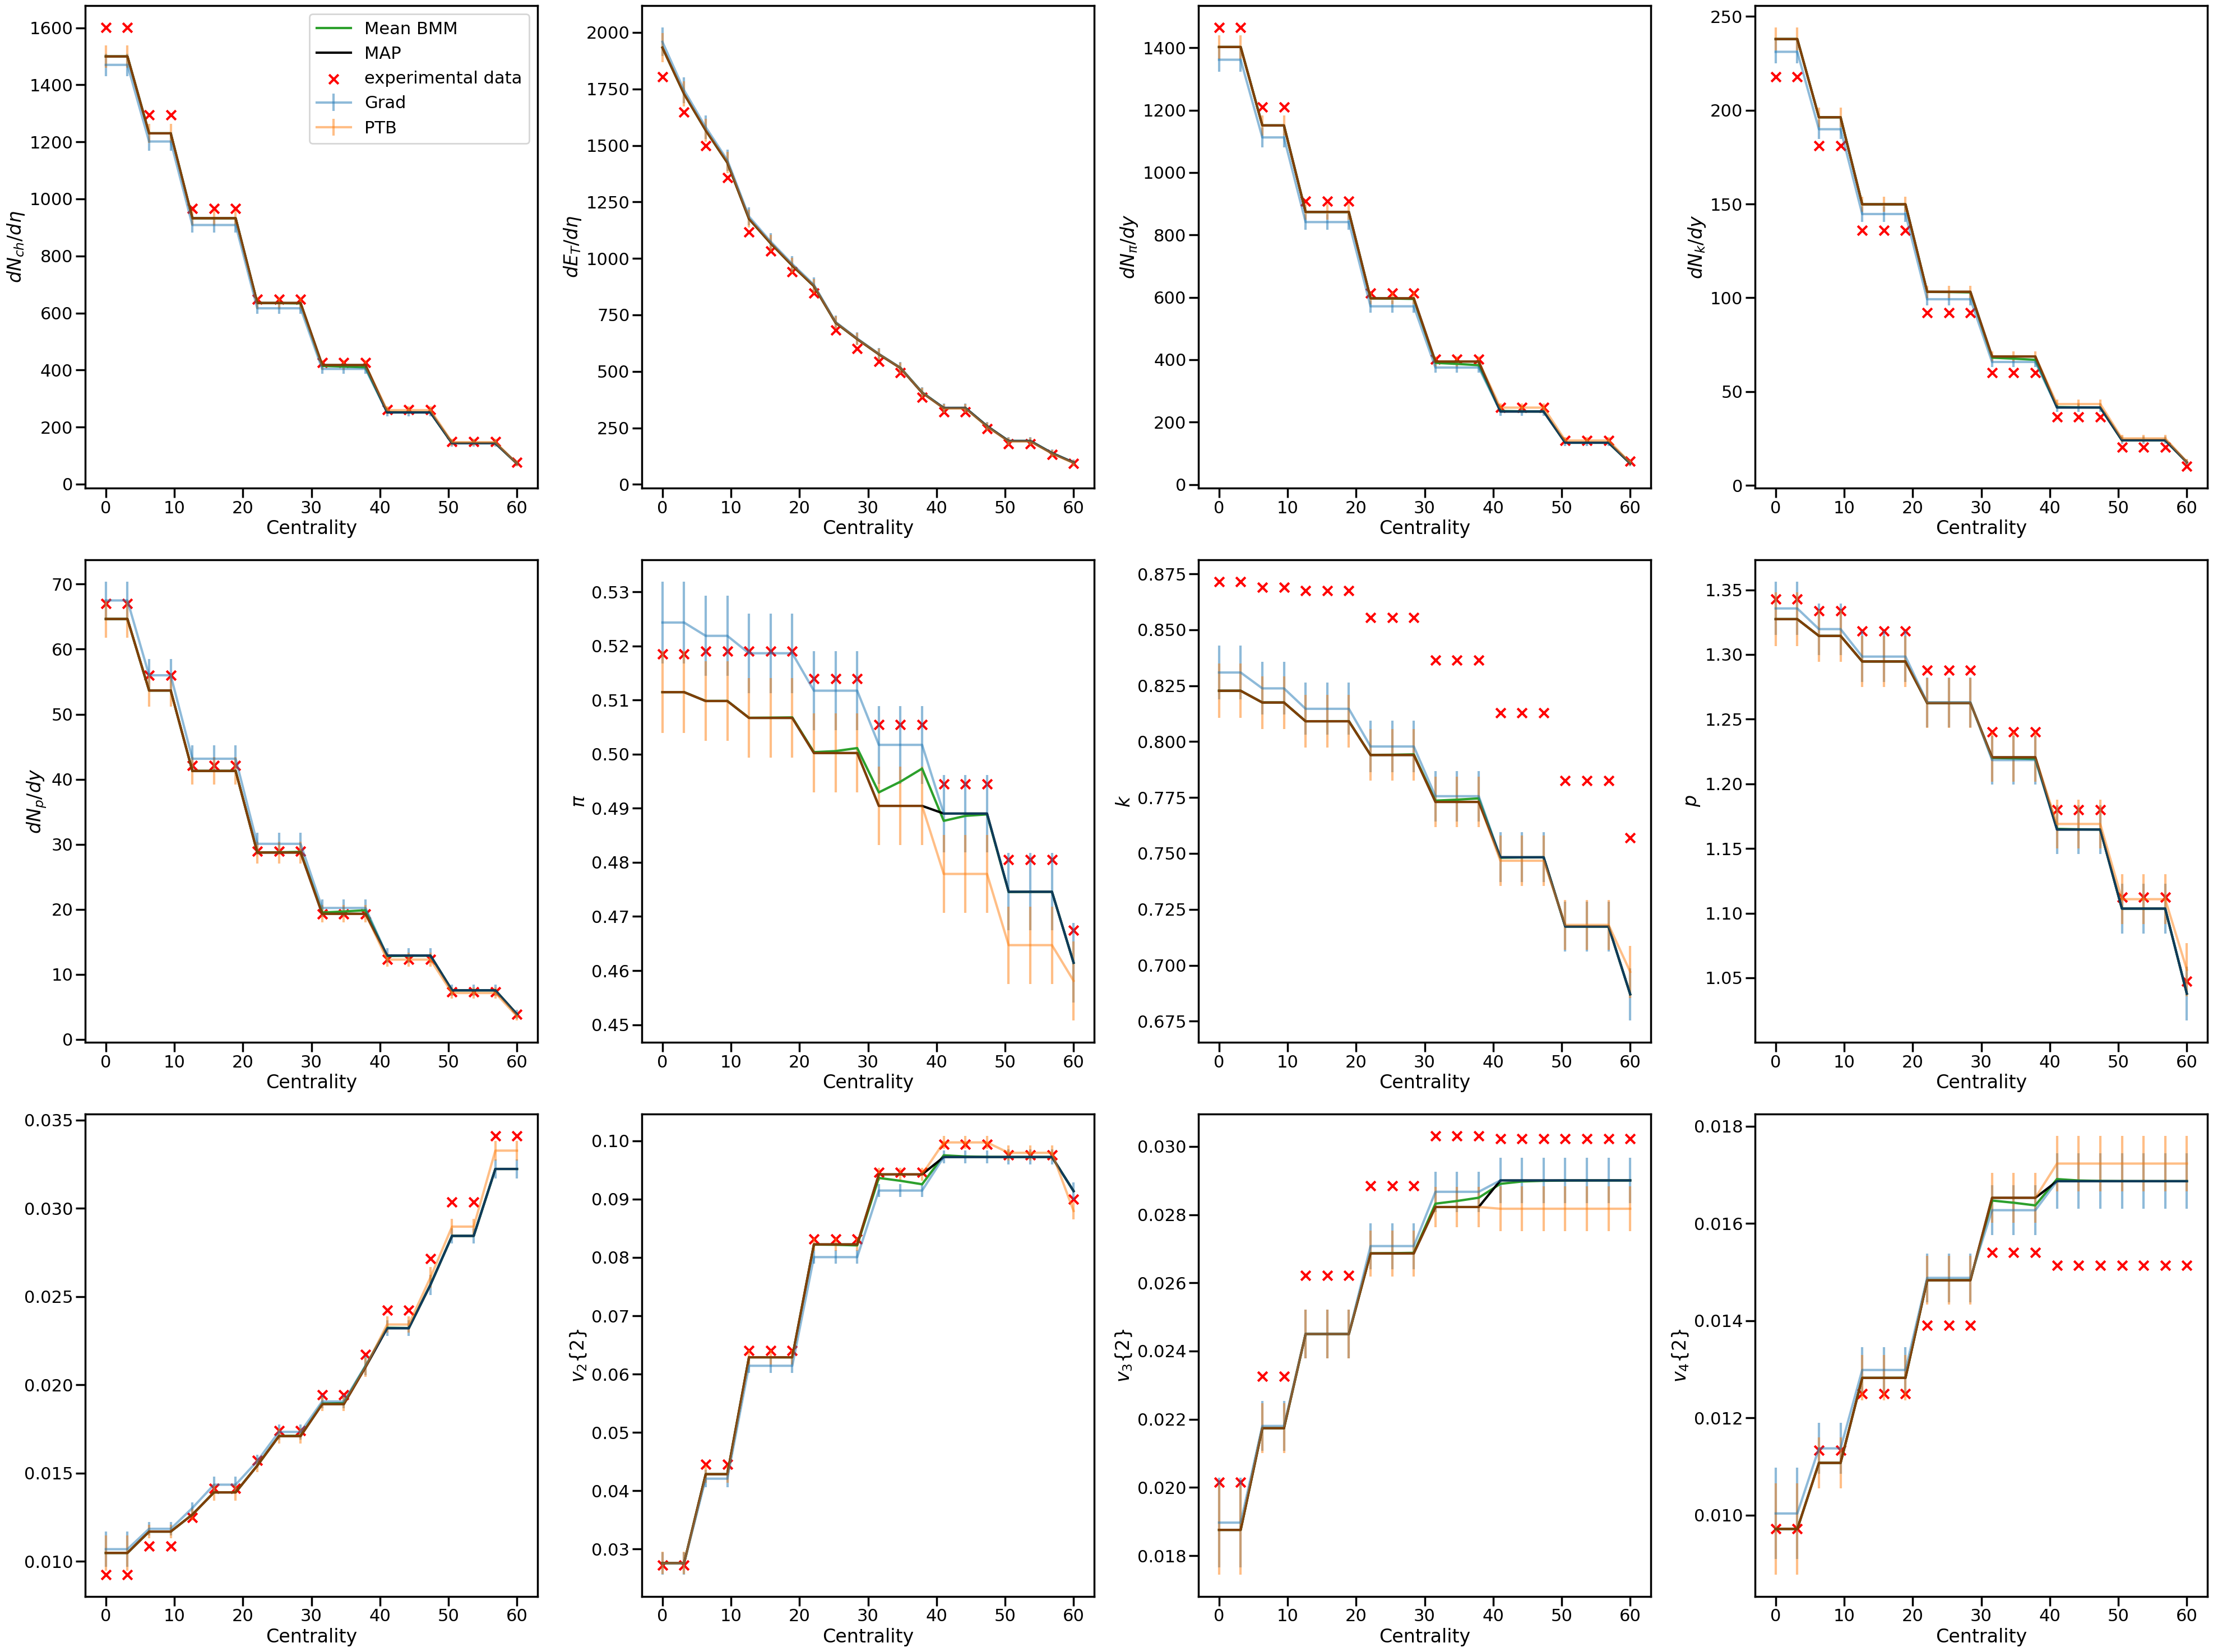

In [ ]:
fig, axs = plt.subplots(3,4, figsize=(40,30))
for i in range(0,12):
    ax_f= axs.flatten()[i]
    ax_f.errorbar(g, m1_prediction[0][:,i].flatten(), 
                yerr=m1_prediction[1][:,i].flatten(), 
                label='Grad', alpha=0.5)
    ax_f.errorbar(g, m2_prediction[0][:,i].flatten(), 
                yerr=m1_prediction[1][:,i].flatten(),
                label='PTB', alpha=0.5)
    # ax_f.plot(plot_g, m1_prediction[0][:,i].flatten(),
    #             label='Grad', alpha=0.8)
    # ax_f.plot(plot_g, m2_prediction[0][:,i].flatten(), 
    #             label='PTB', alpha=0.8)
    ax_f.plot(g, mean[0][i,:].flatten(), label='Mean BMM')
    ax_f.plot(g, map_prediction[i,:].flatten(), label='MAP', color='k')
    #ax_f.plot(plot_g, true_output[0], label='truth')
    ax_f.scatter(g,exp_data[0][:,i].flatten(), marker='x', label='experimental data', color='r')
    ax_f.set_xlabel('Centrality')
    #ax_f.set_ylim(1.2,3.2)
    ax_f.set_ylabel(obs_tex_labels[obs_names[i]])
    if i ==0:
        ax_f.legend()
plt.tight_layout()
fig.savefig(outdir+'/figures/'+'MAP_', dpi=100)

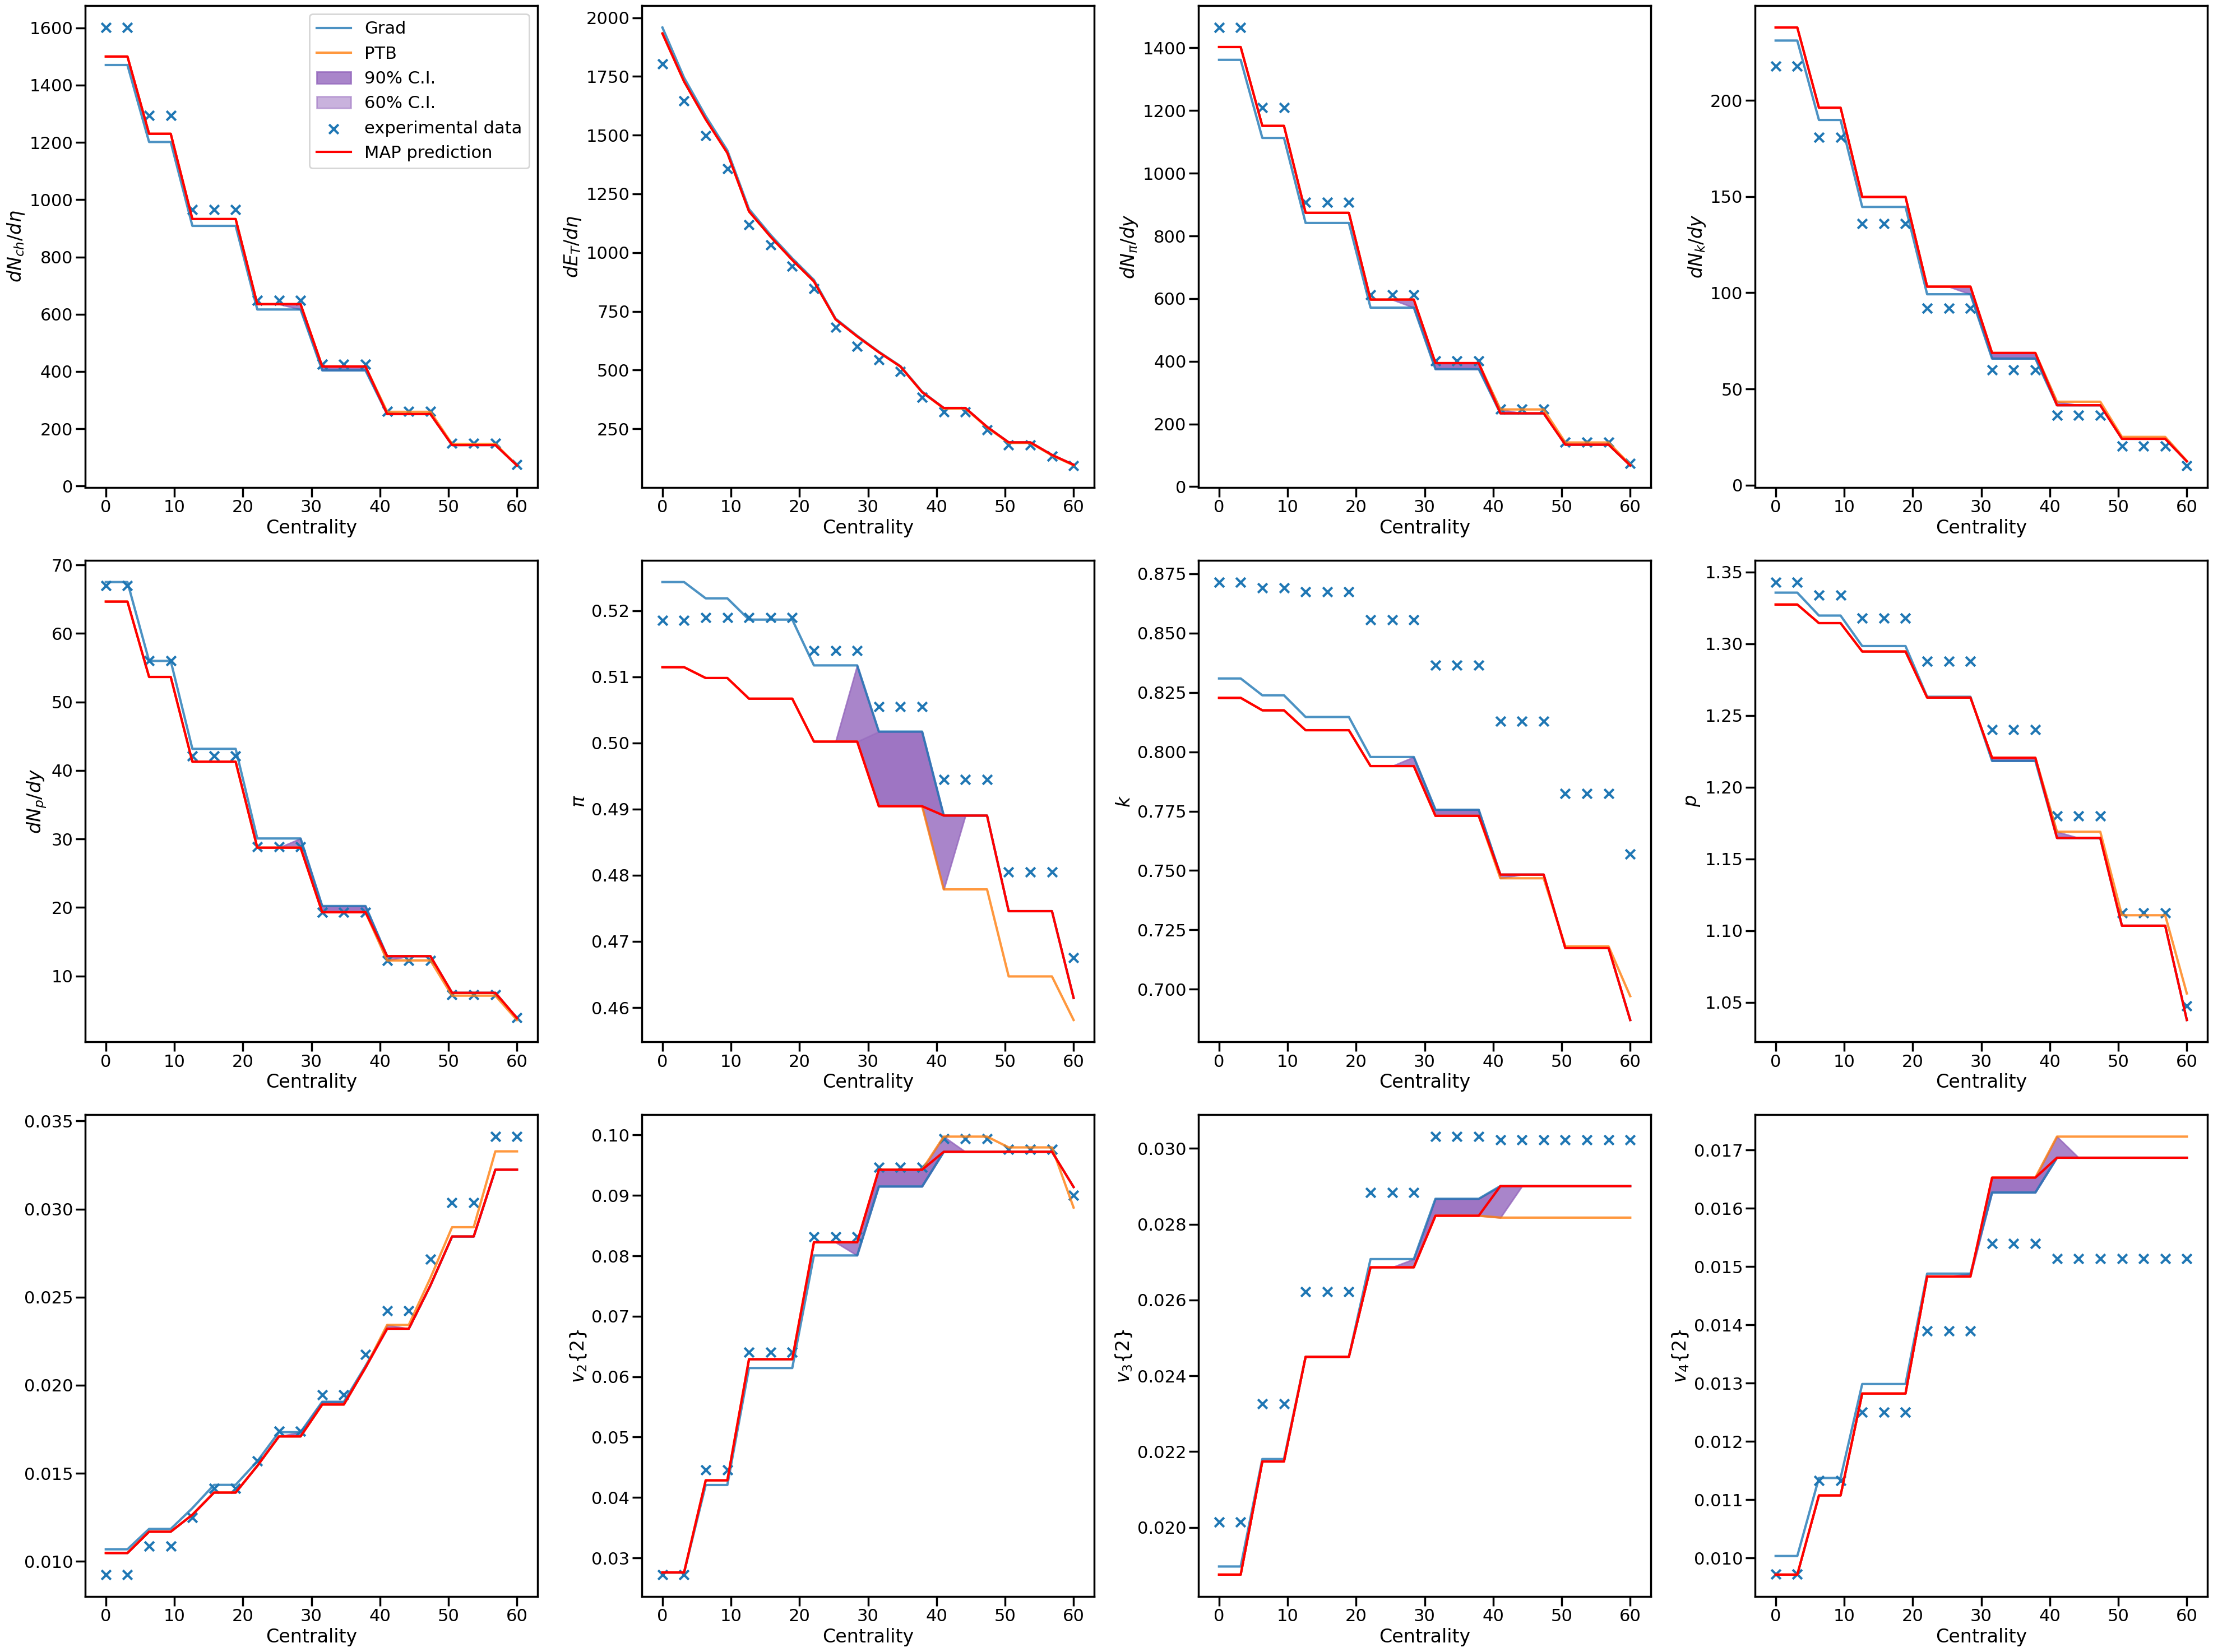

In [ ]:
#sns.set_context('poster')
fig, axs = plt.subplots(3, 4, figsize=(40,30))
for i in range(0,12):
    ax = axs.flatten()[i]
    #fig, ax = plt.subplots(figsize=(10,10))
    #ax.plot(plot_g, mean[0][i,:].flatten(), label='posterior mean')
    # ax_f.errorbar(plot_g, m1_prediction[0][:,i].flatten(), 
    #             yerr=m1_prediction[1][:,i].flatten(), 
    #             label='Grad', alpha=0.2)
    # ax_f.errorbar(plot_g, m2_prediction[0][:,i].flatten(), 
    #             yerr=m1_prediction[1][:,i].flatten(),
    #             label='PTB', alpha=0.2)
    ax.plot(g, m1_prediction[0][:,i].flatten(),
                label='Grad', alpha=0.8)
    ax.plot(g, m2_prediction[0][:,i].flatten(), 
                label='PTB', alpha=0.8)
    ax.fill_between(g,per5[0][i,:].flatten(),per95[0][i,:].flatten(),color=sns.color_palette()[4], alpha=0.8, label='90% C.I.')
    ax.fill_between(g,per20[0][i,:].flatten(),per80[0][i,:].flatten(), color=sns.color_palette()[4], alpha=0.5, label='60% C.I.')
    #ax.fill_between(plot_g,prior20[0][i,:].flatten(),prior80[0][i,:].flatten(),color=sns.color_palette()[2], alpha=0.2, label='60% C.I. Prior')
    ax.scatter(g,exp_data[0][:,i].flatten(), marker='x', label='experimental data')
    #ax.plot(plot_g, mean_prior[0][i,:].flatten(), label='prior mean')
    ax.plot(g, map_prediction[i,:].flatten(), label='MAP prediction', color='r')
    ax.set_xlabel('Centrality')
    #ax_f.set_ylim(1.2,3.2)
    ax.set_ylabel(obs_tex_labels[obs_names[i]])
    if i==0:
        ax.legend()
plt.tight_layout()
fig.savefig(outdir+'/figures/'+'posterior_', dpi=100)